<a href="https://colab.research.google.com/github/ramoants254/Cat-and-Dog-Image-Classification-Using-Custom-CNN-and-TensorFlow/blob/main/Cat_Dog_Classifier_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset Setup

In [ ]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json  ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d tongpython/cat-and-dog

cp: cannot stat '/content/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/tongpython/cat-and-dog
License(s): CC0-1.0
 99% 215M/218M [00:11<00:00, 22.3MB/s]
100% 218M/218M [00:11<00:00, 19.7MB/s]


## Unzipping the Dataset

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/cat-and-dog.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

## Importing Libraries

In [ ]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import layers, models, Input,Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0,ResNet50,VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image

## Function to check if the filepath exists

In [ ]:
def file_exists(filepath):
    return os.path.isfile(filepath)

## Creating Paths and labels for Training set

In [ ]:
paths=[]
labels=[]
for dirname, _, filenames in os.walk('/content/training_set'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        if 'dog' in filename:
            labels.append('dog')
        else:
            labels.append('cat')


for i in range(5):
    print(paths[i],labels[i])

/content/training_set/training_set/cats/cat.693.jpg cat
/content/training_set/training_set/cats/cat.2925.jpg cat
/content/training_set/training_set/cats/cat.2423.jpg cat
/content/training_set/training_set/cats/cat.20.jpg cat
/content/training_set/training_set/cats/cat.3473.jpg cat


## Creating Paths and labels for Testing set

In [ ]:
test_paths=[]
test_labels=[]
for dirname, _, filenames in os.walk('/content/test_set'):
    for filename in filenames:
        test_paths.append(os.path.join(dirname, filename))
        if 'dog' in filename:
            test_labels.append('dog')
        else:
            test_labels.append('cat')


for i in range(5):
    print(test_paths[i],test_labels[i])




/content/test_set/test_set/cats/cat.4694.jpg cat
/content/test_set/test_set/cats/cat.4987.jpg cat
/content/test_set/test_set/cats/cat.4795.jpg cat
/content/test_set/test_set/cats/cat.4562.jpg cat
/content/test_set/test_set/cats/cat.4048.jpg cat


## Creating DataFrame for test set

In [ ]:
test_df = pd.DataFrame({'path': test_paths, 'class': test_labels})
test_df['path'] = test_df['path'].apply(lambda x: x if file_exists(x) else None)
test_df.dropna(inplace=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)
test_df.head()

,path,class
0,/content/test_set/test_set/dogs/dog.4571.jpg,dog
1,/content/test_set/test_set/dogs/dog.4719.jpg,dog
2,/content/test_set/test_set/cats/cat.4140.jpg,cat
3,/content/test_set/test_set/cats/cat.4632.jpg,cat
4,/content/test_set/test_set/cats/cat.4973.jpg,cat


In [ ]:
test_df['class'].value_counts()

,count
class,
cat,1013
dog,1012


## Create DataFrame for test set

In [ ]:
df = pd.DataFrame({'path': paths, 'class': labels})
df['path'] = df['path'].apply(lambda x: x if file_exists(x) else None)
df.dropna(inplace=True)
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,path,class
0,/content/training_set/training_set/dogs/dog.13...,dog
1,/content/training_set/training_set/dogs/dog.38...,dog
2,/content/training_set/training_set/dogs/dog.94...,dog
3,/content/training_set/training_set/dogs/dog.38...,dog
4,/content/training_set/training_set/cats/cat.99...,cat


In [ ]:
df['class'].value_counts()

,count
class,
dog,4005
cat,4002


## Plotting random images from training set

In [ ]:
def plot_images(df,rows,cols):
  plt.figure(figsize=(8,10))
  for i in range(rows*cols):
    img=plt.imread(df['path'][i])
    plt.subplot(rows,cols,i+1)
    plt.imshow(img)
    plt.title(df['class'][i])
    plt.axis('off')
    plt.ylabel(df['class'][i])
    plt.xlabel(df['class'][i])
    plt.axis('off')
  plt.show()

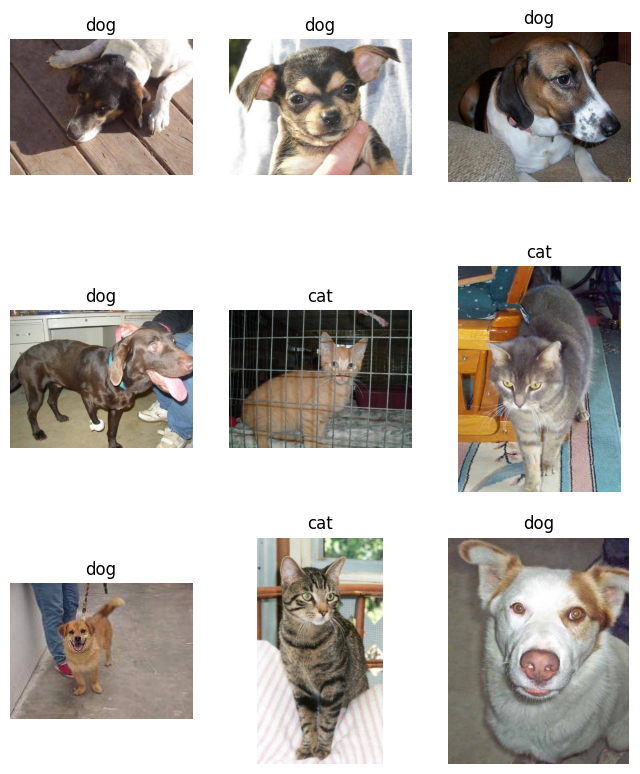

In [ ]:
plot_images(df,3,3)


## Data Augumentation

In [ ]:
IMAGE_SHAPE=(224,224)
BATCH_SIZE=32
test_datagen=ImageDataGenerator(rescale=1./255)
test_generator=test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='class',
    target_size=IMAGE_SHAPE,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 2023 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 2 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


## Data Augumentation for training set

In [ ]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=df,
    x_col='path',
    y_col='class',
    target_size=IMAGE_SHAPE,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 8005 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 2 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


## Defining callbacks

In [ ]:
# Define the learning rate scheduler
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint=ModelCheckpoint('best_model.keras',monitor='val_loss',save_best_only=True)

## Defining a function for ploting history curves

In [ ]:
def plotting_history(history):
  # Plot training & validation accuracy values
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='Train Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title('Model Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  # Plot training & validation loss values
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Model Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()


## Model 1: Custom CNN Model

In [ ]:
inputs = Input(shape=(224,224,3))
x = Conv2D(32, (3,3), activation='relu')(inputs)
x = MaxPooling2D((2,2))(x)

x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(128, (3,3), activation='relu')(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(128, (3,3), activation='relu')(x)
x = MaxPooling2D((2,2))(x)

x = Flatten()(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
                loss='binary_crossentropy',
                metrics=['accuracy'])

model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,179,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,420,609 (5.42 MB)

 Trainable params: 1,420,609 (5.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(train_generator,
                        epochs=15,
                        callbacks=[early_stopping, lr_schedule, checkpoint],
                        validation_data=test_generator)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


251/251 ━━━━━━━━━━━━━━━━━━━━ 117s 419ms/step - accuracy: 0.5365 - loss: 0.6865 - val_accuracy: 0.5981 - val_loss: 0.6471 - learning_rate: 1.0000e-04
Epoch 2/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 129s 399ms/step - accuracy: 0.6166 - loss: 0.6456 - val_accuracy: 0.6327 - val_loss: 0.6408 - learning_rate: 1.0000e-04
Epoch 3/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 140s 393ms/step - accuracy: 0.6728 - loss: 0.5969 - val_accuracy: 0.7163 - val_loss: 0.5578 - learning_rate: 1.0000e-04
Epoch 4/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 142s 390ms/step - accuracy: 0.6966 - loss: 0.5813 - val_accuracy: 0.7484 - val_loss: 0.5323 - learning_rate: 1.0000e-04
Epoch 5/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 105s 405ms/step - accuracy: 0.7003 - loss: 0.5718 - val_accuracy: 0.7331 - val_loss: 0.5289 - learning_rate: 1.0000e-04
Epoch 6/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 137s 393ms/step - accuracy: 0.7099 - loss: 0.5579 - val_accuracy: 0.7158 - val_loss: 0.5481 - learning_rate: 1.0000e-04
Epoch 7/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 146s 411ms/

In [ ]:
model.evaluate(test_generator)

64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.8058 - loss: 0.4261


[0.41512107849121094, 0.8086999654769897]

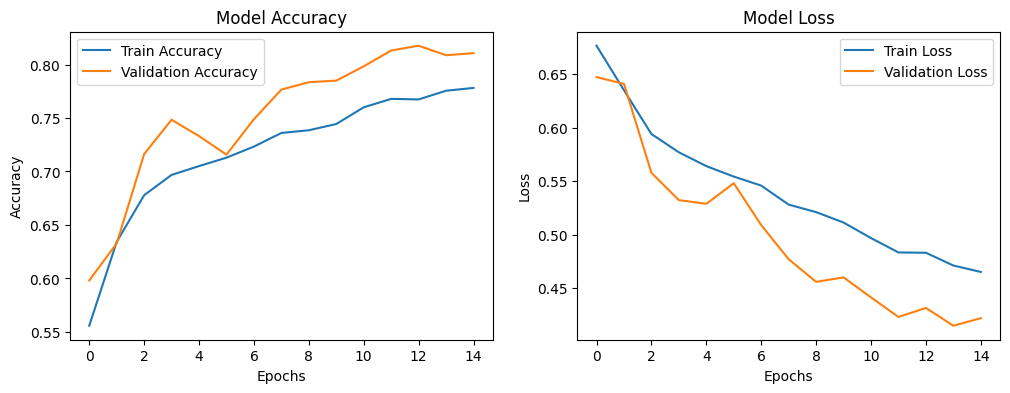

In [ ]:
plotting_history(history)


## A function to make predictions

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

def prediction(model, path):
    img = image.load_img(path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = img / 255.0  # Ensure this matches your training preprocessing
    img = np.expand_dims(img, axis=0)

    result = model.predict(img)

    if result[0][0] > 0.5:
        print('Dog')
    else:
        print('Cat')

    return result


In [ ]:
prediction(model,'/content/test_set/test_set/cats/cat.4005.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Cat


array([[0.26613784]], dtype=float32)

In [ ]:
prediction(model,'/content/test_set/test_set/dogs/dog.4198.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Dog


array([[0.916335]], dtype=float32)